In [143]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numba import njit, prange
from scipy.sparse import csc_matrix, linalg as sla
from scipy.optimize import root, curve_fit
from scipy.special import iv, kv

In [144]:
R1 = 0.1
R2 = 8
E1 = 1
E2 = 2
r = np.linspace(R1, R2, 1000)
i_E1 = np.argmin(abs(r-E1))
i_E2 = np.argmin(abs(r-E2))
dr = (np.max(r)-np.min(r))/(len(r)-1)
n0 = (8/r**2)*(np.tanh(25*(r-E1))-np.tanh(25*(r-E2)))
#n0 = (r**-1.5 - R2**-1.5)/R1**-1.5
#n0[:50] = 0
#n0[200:] = 0
#n0 = np.exp(-(r-R1)*5)
#n0 = np.exp(-((r-4.5)/1)**2)
#n0 = np.zeros(len(r))
#n0[:50] = 1
#phi_wire = -10
n0[0] = 0
phi_wire = 0
h_T = -phi_wire/np.log(R1/R2)

In [145]:
#Poisson Solver
@njit(parallel=True)
def M(r, dr):
    col = np.zeros(3*len(r)-4)
    row = np.zeros(3*len(r)-4)
    data = np.zeros(3*len(r)-4)
    data[0] = 1
    for i in prange(1, len(r)-1):
        row[3*i-1:3*i+2] = i
        col[3*i-1] = i-1
        col[3*i] = i
        col[3*i+1] = i+1
        data[3*i-1] = (r[i]-dr/2)/(dr**2*r[i])
        data[3*i] = -2/dr**2
        data[3*i+1] = (r[i]+dr/2)/(dr**2*r[i])
    row[-1] = len(r)-1
    col[-1] = len(r)-1
    data[-1] = len(r)-1
    return data, col, row

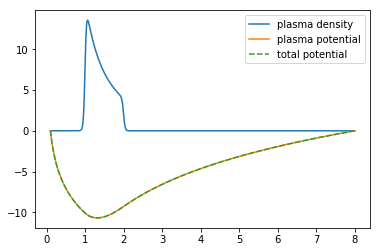

In [146]:
data, col, row = M(r, dr)
A = csc_matrix((data, (row, col)), shape=(len(r), len(r)))
lu = sla.splu(A)

phi = lu.solve(n0)
phi_T = (phi_wire/np.log(R1/R2))*np.log(r/R2)

plt.plot(r, n0, label='plasma density')
plt.plot(r, phi, label='plasma potential')
plt.plot(r, phi+phi_T, label='total potential', linestyle="dashed")
plt.legend()
plt.show()

In [147]:
I0 = iv(0, r)
I1 = iv(1, r)
dI0 = np.zeros(len(r))
for i in range(len(r)-1):
    dI0[i] = (I0[i+1]-I0[i])/dr
dI0[-1] = 2*dI0[-2] - dI0[-3]

K0 = kv(0, r)
K1 = kv(1, r)
dK0 = np.zeros(len(r))
for i in range(len(r)-1):
    dK0[i] = (K0[i+1]-K0[i])/dr
dK0[-1] = 2*dK0[-2] - dK0[-3]

#plt.plot(r, I0, label='I0')
#plt.plot(r, I1, label='I1')
#plt.plot(r, dI0, label='dI0', linestyle='dashed')
#plt.legend()
#plt.show()

#plt.plot(r, K0, label='K0')
#plt.plot(r, K1, label='K1')
#plt.plot(r, -dK0, label='dK0', linestyle='dashed')
#plt.legend()
#plt.show()

In [148]:
def alpha(r, r_j):
    return(iv(0, r)*kv(0, r_j)-iv(0, r_j)*kv(0, r))
def dalpha(r, r_j):
    return(iv(1, r)*kv(0, r_j)+iv(0, r_j)*kv(1, r))

In [149]:
@njit(parallel=True)
def Green(r, r_prime, r_i, r_o, alpha_inv, alpha1, alpha2):
    green = np.empty((len(r_prime), len(r)))
    for i in prange(len(r)):
        for j in range(len(r_prime)):
            if r[i] <= r_prime[j]:
                green[i, j] = alpha1[i]*alpha2[j]/alpha_inv[j]
            elif r[i]>r_prime[j]:
                green[i, j] = alpha2[i]*alpha1[j]/alpha_inv[j]
    return green

In [150]:
alpha_inv = r*(alpha(r, R1)*dalpha(r, R2)-alpha(r, R2)*dalpha(r, R1))
alpha1 = alpha(r, R1)
alpha2 = alpha(r, R2)
#plt.plot(r, alpha1, label='1')
#plt.plot(r, alpha2, label='2')
#plt.plot(r, 1/alpha_inv, label='3')
#plt.legend()
#plt.show()
green = Green(r, r, R1, R2, alpha_inv, alpha1, alpha2)
#plt.imshow(green)
#plt.show()

phi_green = np.zeros(len(r))
for i in range(len(r)):
    phi_green[i] = np.sum(r*green[i]*n0*dr)

#plt.plot(r, phi_green, color='g', linestyle='dashed')
#plt.show()

In [151]:
dn0 = np.zeros(len(r))
in0 = np.zeros(len(r))
dphi = np.zeros(len(r))

dn0[0] = (r[1]**2*n0[1] - r[0]**2*n0[0])/dr
in0[0] = dr*(r[1]*n0[1] + r[0]*n0[0])/2
dphi[0] = (r[0]+dr/2)*(phi[1]-phi[0])/dr
for i in range(len(r)-1):
    dn0[i] = (r[i+1]**2*n0[i+1] - r[i]**2*n0[i])/dr
    in0[i] = in0[i-1] + dr*(r[i+1]*n0[i+1] + r[i]*n0[i])/2
    dphi[i] = (r[i]+dr/2)*(phi[i+1]-phi[i])/dr
dn0[-1] = 2*dn0[-2] - dn0[-3]
in0[-1] = 2*in0[-2] - in0[-3]

N = np.empty((len(r), len(r)))
for i in range(len(r)):
    N[i] = -(dn0[i]/r[i])*r*green[i]*dr
    N[i, i] += in0[i]
#w, v = sp.linalg.eig(N)
w, v = np.linalg.eig(N)
v = np.transpose(v)

In [152]:
@njit(parallel=True)
def mode_finder(v_real):

    sum_der = np.zeros(len(v_real))
    v_abs = np.sqrt(v_real**2)
    max_v  = np.max(v_abs)

    for i in prange(len(v_real)):
        sum_der[i] = np.max(np.sqrt((v_real[i, 1:]-v_real[i, :-1])**2)/max_v)

    target = np.min(sum_der)+0.01*np.std(sum_der)
    i_target = np.zeros(len(v_real))-1
    for i in prange(len(v_real)-1):
        if sum_der[i] <= target:
            n = 0
            for j in range(len(v_real[0])-1):
                if v_abs[i][j+1]/max_v<=1e-6 and v_abs[i][j-1]/max_v<=1e-6 and v_abs[i][j]/max_v>=0.01:
                    n += 1
            if n == 0:
                i_target[i] = int(i)

    return i_target[i_target>=0]

In [153]:
v_real = np.real(v)
i_target = mode_finder(v_real)
i_target = np.array([int(i) for i in i_target])
print(i_target)

[0 1]


[185, 185]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  # This is added back by InteractiveShellApp.init_path()


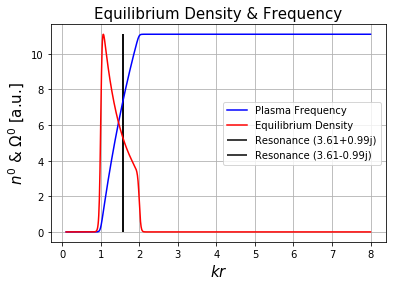

In [154]:
v_real = np.real(v)

i_res = []
for i in range(len(i_target)):
    i_res.append(np.argmin(abs(in0-np.real(w[i_target[i]]))))
print(i_res)
plt.plot(r, in0, "b", label='Plasma Frequency')
plt.plot(r, np.max(in0)*n0/np.max(n0), "r", label='Equilibrium Density')
#for i in range(len(i_res)):
plt.vlines(r[i_res[0]], 0, np.max(in0), "k", label='Resonance '+str(round(w[i_target[0]]/2, 2)))
plt.vlines(r[i_res[1]], 0, np.max(in0), "k", label='Resonance '+str(round(w[i_target[1]]/2, 2)))
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^0$ & $\Omega^0$ [a.u.]', fontsize=15)
plt.legend()
plt.title('Equilibrium Density & Frequency', fontsize=15)
plt.grid()
#plt.savefig('resonance.png', dpi=400)
plt.show()

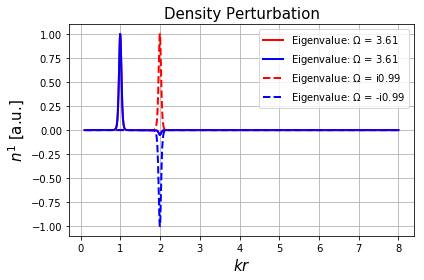

In [155]:
#real
#plt.plot(r, n1/np.max(n1), label='Shooting: $\Omega$ = '+str(round(omega[0]/2, 2)), color="k", linewidth=2)
#plt.plot(r, np.real(v[int(i_target[1])])/np.max(abs(np.real(v[int(i_target[1])]))), 'b', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2)), linewidth=2)
#plt.plot(r, -np.real(v[int(i_target[0])])/np.max(abs(np.real(v[int(i_target[0])]))), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
#imaginary
plt.plot(r, np.real(v[int(i_target[0])])/np.max(abs(np.real(v[int(i_target[0])]))), 'r', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[0])])/2, 2)), linewidth=2)
plt.plot(r, np.real(v[int(i_target[1])])/np.max(abs(np.real(v[int(i_target[1])]))), 'b', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2)), linewidth=2)
if np.imag(w[i_target[0]]) != 0:
    plt.plot(r, np.imag(v[int(i_target[0])])/np.max(abs(np.imag(v[int(i_target[0])]))), 'r', linestyle='dashed', label='Eigenvalue: $\Omega$ = i'+str(round(np.imag(w[i_target[0]])/2, 2)), linewidth=2)
if np.imag(w[i_target[1]]) != 0:
    plt.plot(r, np.imag(v[int(i_target[1])])/np.max(abs(np.imag(v[int(i_target[1])]))), 'b', linestyle='dashed', label='Eigenvalue: $\Omega$ = -i'+str(round(np.imag(-w[i_target[1]])/2, 2)), linewidth=2)
#plt.plot(r, -v_real[int(i_target[1])]/np.max(abs(v_real[int(i_target[1])])), 'g', linestyle='dashed', label='Eigenvalue: $\Omega$ = '+str(round(np.real(w[int(i_target[1])])/2, 2))+' - i'+str(round(abs(np.imag(w[int(i_target[1])])/2), 2)), linewidth=2)

#plt.plot(r, n0/np.max(n0), 'r', linestyle='dotted', label='Initial Density', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
#plt.savefig('equi_vs_pert35.png', dpi=400)
plt.savefig('eigen_imag.png', dpi=400)
plt.show()

15.999999999555534


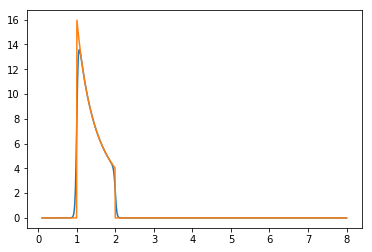

In [156]:
n0_ana = 1/r**2
n0_ana[:i_E1] = 0
n0_ana[i_E2:] = 0
print(n0[int((i_E1+i_E2)/2)]/n0_ana[int((i_E1+i_E2)/2)])
plt.plot(r, n0)
plt.plot(r, (n0[int((i_E1+i_E2)/2)]/n0_ana[int((i_E1+i_E2)/2)])*n0_ana)
plt.show()

In [157]:

i_E1 = np.argmin(abs(r-E1))
i_E2 = np.argmin(abs(r-E2))
G11 = green[i_E1, i_E1]
G22 = green[i_E2, i_E2]
G12 = green[i_E1, i_E2]
n0 = (8/r**2)*(np.tanh(25*(r-E1))-np.tanh(25*(r-E2)))
n0_norm = n0[int((i_E1+i_E2)/2)]*r[int((i_E1+i_E2)/2)]**2

p = (G11 - G22 - np.log(E2/E1))/2
q = (G12**2 - G11*G22 - np.log(E2/E1)*G11)/4

if (p/2)**2 > q:
    omega_p = -p/2 + np.sqrt((p/2)**2 - q)
    omega_m = -p/2 - np.sqrt((p/2)**2 - q)
else:
    omega_p = -p/2 + 1j*np.sqrt(-(p/2)**2 + q)
    omega_m = -p/2 - 1j*np.sqrt(-(p/2)**2 + q)
print(n0_norm*omega_p, n0_norm*omega_m)

ab_p = G12*(2*np.real(omega_p)+G11 - 2j*np.imag(omega_p))/((2*np.real(omega_p)+G11) + 4*np.imag(omega_p)**2)
ab_m = G12*(2*np.real(omega_m)+G11 - 2j*np.imag(omega_m))/((2*np.real(omega_m)+G11) + 4*np.imag(omega_m)**2)
print(ab_p, ab_m)

(3.591872436734523+0.9953551435932365j) (3.591872436734523-0.9953551435932365j)
(0.25335282952941673+3.039748189322963j) (0.25335282952941673-3.039748189322963j)


NameError: name 'stop' is not defined

In [ ]:
c = 2.99e10 #Speed of light
e = 1.602e-20*c #elementary charge
I = 2.5e4*c
k = 1/(np.pi*(E2+E1))
n0 = 5e4
print(n0_norm*omega_p*c**2*e*n0/(I*k))
print(n0_norm*omega_m*c**2*e*n0/(I*k))

31155.743613413815
1440.1292974718253


In [179]:
i_x = np.argmin(abs(r-5))
i_y = np.argmin(abs(r-2))
#a = np.zeros((i_x,i_y))
#ab_p = np.zeros((i_x,i_y),dtype=np.complex_)
#ab_m = np.zeros((i_x,i_y),dtype=np.complex_)
omega_p = np.zeros((i_x,i_y),dtype=np.complex_)
omega_m = np.zeros((i_x,i_y),dtype=np.complex_)
eps = 0.1

for i in range(i_x):
    alpha_inv = r*(alpha(r, eps*r[i])*dalpha(r, R2)-alpha(r, R2)*dalpha(r, eps*r[i]))
    alpha1 = alpha(r, eps*r[i])
    alpha2 = alpha(r, R2)
    green = Green(r, r, eps*r[i], R2, alpha_inv, alpha1, alpha2)
    for j in range(i+1, i+i_y):
        G11 = green[i, i]
        G22 = green[j, j]
        G12 = green[i, j]
        n0_norm = 1
        p = (G11 - G22 - np.log(r[j]/r[i]))/2
        q = (G12**2 - G11*G22 - np.log(r[j]/r[i])*G11)/4

        if (p/2)**2 > q:
            omega_p[i, j-i] = n0_norm*(-p/2 + np.sqrt((p/2)**2 - q))
            omega_m[i, j-i] = n0_norm*(-p/2 - np.sqrt((p/2)**2 - q))
            #ab_p[i, j-i] = G12/(2*omega_p[i, j-i]+G11)
            #ab_m[i, j-i] = G12/(2*omega_m[i, j-i]+G11)
        else:
            omega_p[i, j-i] = n0_norm*(-p/2 + 1j*np.sqrt(-(p/2)**2 + q))
            omega_m[i, j-i] = n0_norm*(-p/2 - 1j*np.sqrt(-(p/2)**2 + q))
            #ab_p[i, j-i] = G12*(2*np.real(omega_p[i, j-i])+G11 - 2j*np.imag(omega_p[i, j-i]))/((2*np.real(omega_p[i, j-i])+G11) + 4*np.imag(omega_p[i, j-i])**2)
            #ab_m[i, j-i] = G12*(2*np.real(omega_m[i, j-i])+G11 - 2j*np.imag(omega_m[i, j-i]))/((2*np.real(omega_m[i, j-i])+G11) + 4*np.imag(omega_m[i, j-i])**2)

        #a[i, j-i] = (r[j]+r[i])/2
        #a[i, j-i] = (r[j]-r[i])/np.log(r[j]/r[i])
        #a[i, j-i] = np.log(r[j]/r[i])
#ab_p = np.nan_to_num(ab_p)
#ab_m = np.nan_to_num(ab_m)

In [159]:
ab_p = np.nan_to_num(ab_p)
ab_m = np.nan_to_num(ab_m)
ab = np.real(ab_p)
print(np.min(ab), np.max(ab), np.mean(ab))

-326.42811811409285 49.04153920353915 -0.003418398426099411


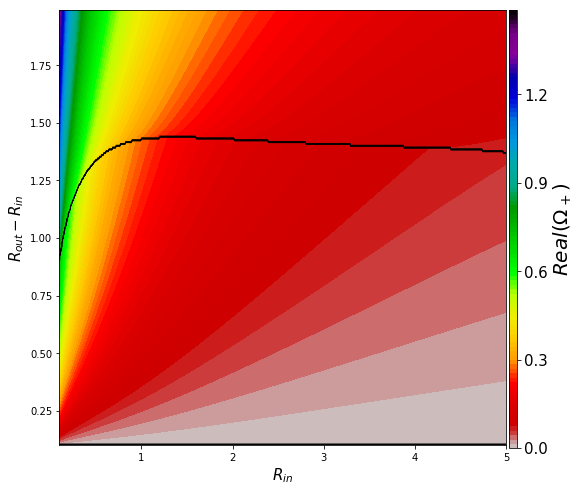

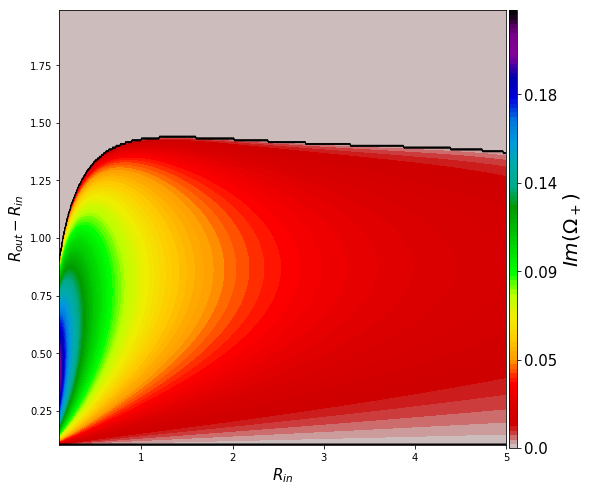

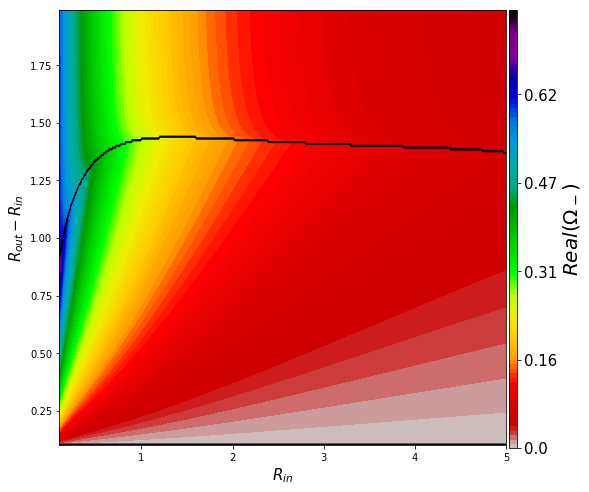

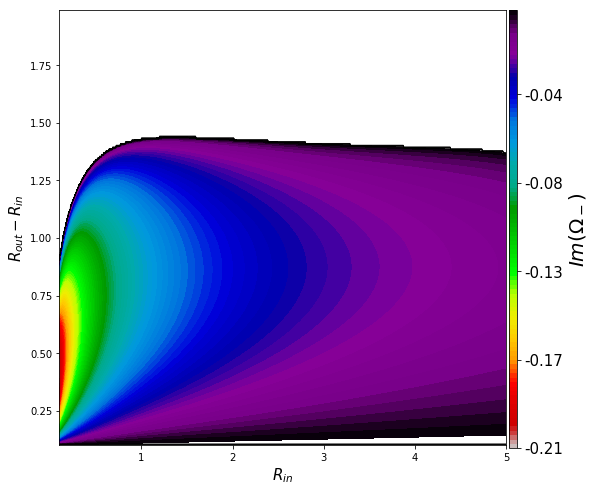

In [180]:
mask = np.zeros((i_x,i_y))
mask[np.imag(omega_p)==0] = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = np.real(omega_p)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)
contour_mask = np.arange(0, 1.1, 0.1)
contour_a = np.arange(np.min(a), np.max(a), (np.max(a)-np.min(a))/30)

im = ax.contourf(r[:i_x], r[:i_y], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(r[:i_x], r[:i_y], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = f'$Real(\Omega_+)$',fontsize=20)
#plt.savefig('omega_pr.png', format = 'png', bbox_inches="tight", dpi=300)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = np.imag(omega_p)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:i_x], r[:i_y], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(r[:i_x], r[:i_y], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$Im(\Omega_+)$',fontsize=20)
#plt.savefig('omega_pi.png', format = 'png', bbox_inches="tight", dpi=300)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = np.real(omega_m)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:i_x], r[:i_y], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(r[:i_x], r[:i_y], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$Real(\Omega_-)$',fontsize=20)
#plt.savefig('omega_mr.png', format = 'png', bbox_inches="tight", dpi=300)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = np.imag(omega_m)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:i_x], r[:i_y], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(r[:i_x], r[:i_y], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$Im(\Omega_-)$',fontsize=20)
#plt.savefig('omega_mi.png', format = 'png', bbox_inches="tight", dpi=300)

In [ ]:
mask = np.zeros((len(r)//2,len(r)//2))
mask[S<=0] = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = abs(np.real(ab_p))
omega[omega<1e-3] = 1e-3
omega = np.log10(omega)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)
contour_mask = np.arange(0, 1.1, 0.1)
contour_a = np.arange(np.min(a), np.max(a), (np.max(a)-np.min(a))/30)

im = ax.contourf(r[:len(r)//2], r[:len(r)//2], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
#im_mask = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$p^2/4-q$',fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = abs(np.imag(ab_p))
omega[omega<1e-3] = 1e-3
omega = np.log10(omega)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:len(r)//2], r[:len(r)//2], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
#im_mask = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$p^2/4-q$',fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = abs(np.real(ab_m))
omega[omega<1e-3] = 1e-3
omega = np.log10(omega)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:len(r)//2], r[:len(r)//2], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
#im_mask = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$p^2/4-q$',fontsize=20)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
omega = abs(np.imag(ab_m))
omega[omega<1e-3] = 1e-3
omega = np.log10(omega)

contours_o = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)

im = ax.contourf(r[:len(r)//2], r[:len(r)//2], np.transpose(omega), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
#im_mask = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(mask), contour_mask, colors='k', linestyles="solid", linewidths=0.5)
#im_a = ax.contour(r[:len(r)//2], r[:len(r)//2], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5))
tick_labels = [str(round(i, 2)) for i in np.arange(np.min(omega), np.max(omega)*1.1, (np.max(omega)*1.1-np.min(omega))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$p^2/4-q$',fontsize=20)

In [ ]:
mask = np.zeros((len(r)//2,len(r)//4))
mask[S<=0] = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

contours_o = np.arange(np.min(omega_m), np.max(omega_m)*1.1, (np.max(omega_m)*1.1-np.min(omega_m))/100)
#contours_S = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/100)
contour_mask = np.arange(0, 1.1, 0.1)
contour_a = np.arange(np.min(a), np.max(a), (np.max(a)-np.min(a))/10)

im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(omega_m), contours_o, cmap='nipy_spectral_r')
#im = ax.contourf(r[:len(r)//2], r[:len(r)//4], np.transpose(mask*S), contours_S, cmap='nipy_spectral')
im_mask = ax.contour(r[:len(r)//2], r[:len(r)//4], np.transpose(mask), contour_mask, colors='w', linestyles="solid", linewidths=0.5)
im_a = ax.contour(r[:len(r)//2], r[:len(r)//4], np.transpose(a), contour_a, colors='k', linestyles="dashed", linewidths=0.5)
ax.set_xlabel(r"$R_{in}$", fontsize = 15)
ax.set_ylabel(r"$R_{out}-R_{in}$", fontsize = 15)
#ax.text(2.1, 0.8, r'$\lambda_{D0}/R$ = %1.2f' %(np.sqrt(T0*T[0]/(4*np.pi*e**2*n0))/R_coil), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(omega_m), np.max(omega_m)*1.1, (np.max(omega_m)*1.1-np.min(omega_m))/5))
tick_labels = [str(abs(round(i, 2))) for i in np.arange(np.min(omega_m), np.max(omega_m)*1.1, (np.max(omega_m)*1.1-np.min(omega_m))/5)]
#cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5))
#tick_labels = [str(abs(round(i, 1))) for i in np.arange(np.min(mask*S), np.max(mask*S), (np.max(mask*S)-np.min(mask*S))/5)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$p^2/4-q$',fontsize=20)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 250 but corresponding boolean dimension is 500

In [ ]:
print(np.min(np.imag(omega_p)), np.max(np.imag(omega_p)),np.mean(np.imag(omega_p)))

0.0 0.0 0.0


ValueError: x and y must have same first dimension, but have shapes (500,) and (150,)

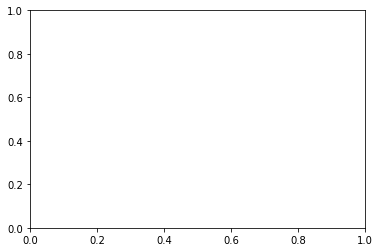

In [ ]:
plt.plot(r[100:600], S[100, 100:600])
plt.plot(r[200:600], S[200, 200:600])
plt.plot(r[300:600], S[300, 300:600])
plt.plot(r[400:600], S[400, 400:600])
plt.plot(r[500:600], S[500, 500:600])
plt.grid()
plt.show()
S_min = np.zeros(len(r))
for i in range(len(r)):
    S_min[i] = np.min(S[i, :])
plt.plot(r, S_min)
plt.grid()
plt.show()

In [ ]:
def phase_finder(n1_real, v_real, n1_imag, v_imag, para):
    def fun(para):
        real = np.sum((n1_real-para[0]*(v_real*np.cos(para[1])-v_imag*np.sin(para[1])))**2)
        imag = np.sum((n1_imag-para[0]*(v_real*np.sin(para[1])+v_imag*np.cos(para[1])))**2)
        return real, imag    
    Root = root(fun, para)
    return(Root)

In [ ]:
n1_imag = A.dot(-phi_i)
n1_real = A.dot(-phi_r)
v_real = np.real(v[i_target[0]])
v_imag = np.imag(v[i_target[0]])
Root = phase_finder(n1_real, v_real, n1_imag, v_imag, [1e4, np.pi])
print(Root)
para = Root.x
print('omega = '+str(round((para[1]%2*np.pi)/np.pi, 2))+'pi')

plt.plot(r, n1_real, 'b', label='Shooting - Real', linewidth=2)
plt.plot(r, para[0]*(v_real*np.cos(para[1])-v_imag*np.sin(para[1])), 'r', linestyle='dashed', label='Eigenvalue - Real', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('Density Perturbation', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('phaseshift_real.png', dpi=400)
plt.show()

plt.plot(r, n1_imag, 'g', label='Shooting - Imaginary', linewidth=2)
plt.plot(r, para[0]*(v_real*np.sin(para[1])+v_imag*np.cos(para[1])), 'm', linestyle='dashed', label='Eigenvalue - Imaginary', linewidth=2)
plt.legend()
plt.xlabel('$kr$', fontsize=15)
plt.ylabel('$n^1$ [a.u.]', fontsize=15)
plt.title('phaseshift_imag', fontsize=15)
plt.grid()
plt.tight_layout()
plt.savefig('phaseshift_imag.png', dpi=400)
plt.show()

NameError: name 'phi_i' is not defined